# TERM DEPOSIT SUBSCRIPTION PREDICTION

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib
import warnings
warnings.filterwarnings('ignore')




In [2]:
# Load training data
train_bank_file = pd.read_csv('bank-full.csv', delimiter=';')  

# loading testing data
test_bank_file = pd.read_csv('bank.csv', delimiter=';')


# EXPLORATORY DATA ANALYSIS (EDA)

In [3]:
# Show shape and first few rows
print("Shape of dataset:", train_bank_file.shape)
train_bank_file.head()

Shape of dataset: (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
# Check data types and null values
print(train_bank_file.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
None


In [5]:
## checking for duplicated columns
train_bank_file.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [6]:
train_bank_file.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [7]:
# Summary of numerical columns
train_bank_file.describe()


,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64


<Axes: title={'center': 'Target Class Distribution'}, xlabel='y'>

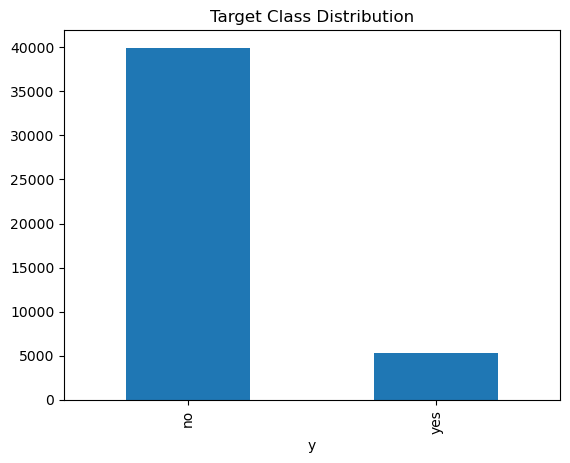

In [8]:
# Distribution of target variable
print(train_bank_file['y'].value_counts(normalize=True))
train_bank_file['y'].value_counts().plot(kind='bar', title='Target Class Distribution')


# Insight on Target Class Distribution


The target variable `y`, indicating client subscription to a term deposit, is highly imbalanced.

Only a small percentage of clients subscribed to the term deposit (target class “yes” ≈ 11%), indicating class imbalance.

This imbalance may bias the model towards the majority class hence the need for appropriate techniques such as:
- adjusting the class weights
- Oversampling using SMOTE

These methods help the model better learn from the minority class (clients who subscribed), ensuring more reliable predictions.



###  Distribution of numerical columns

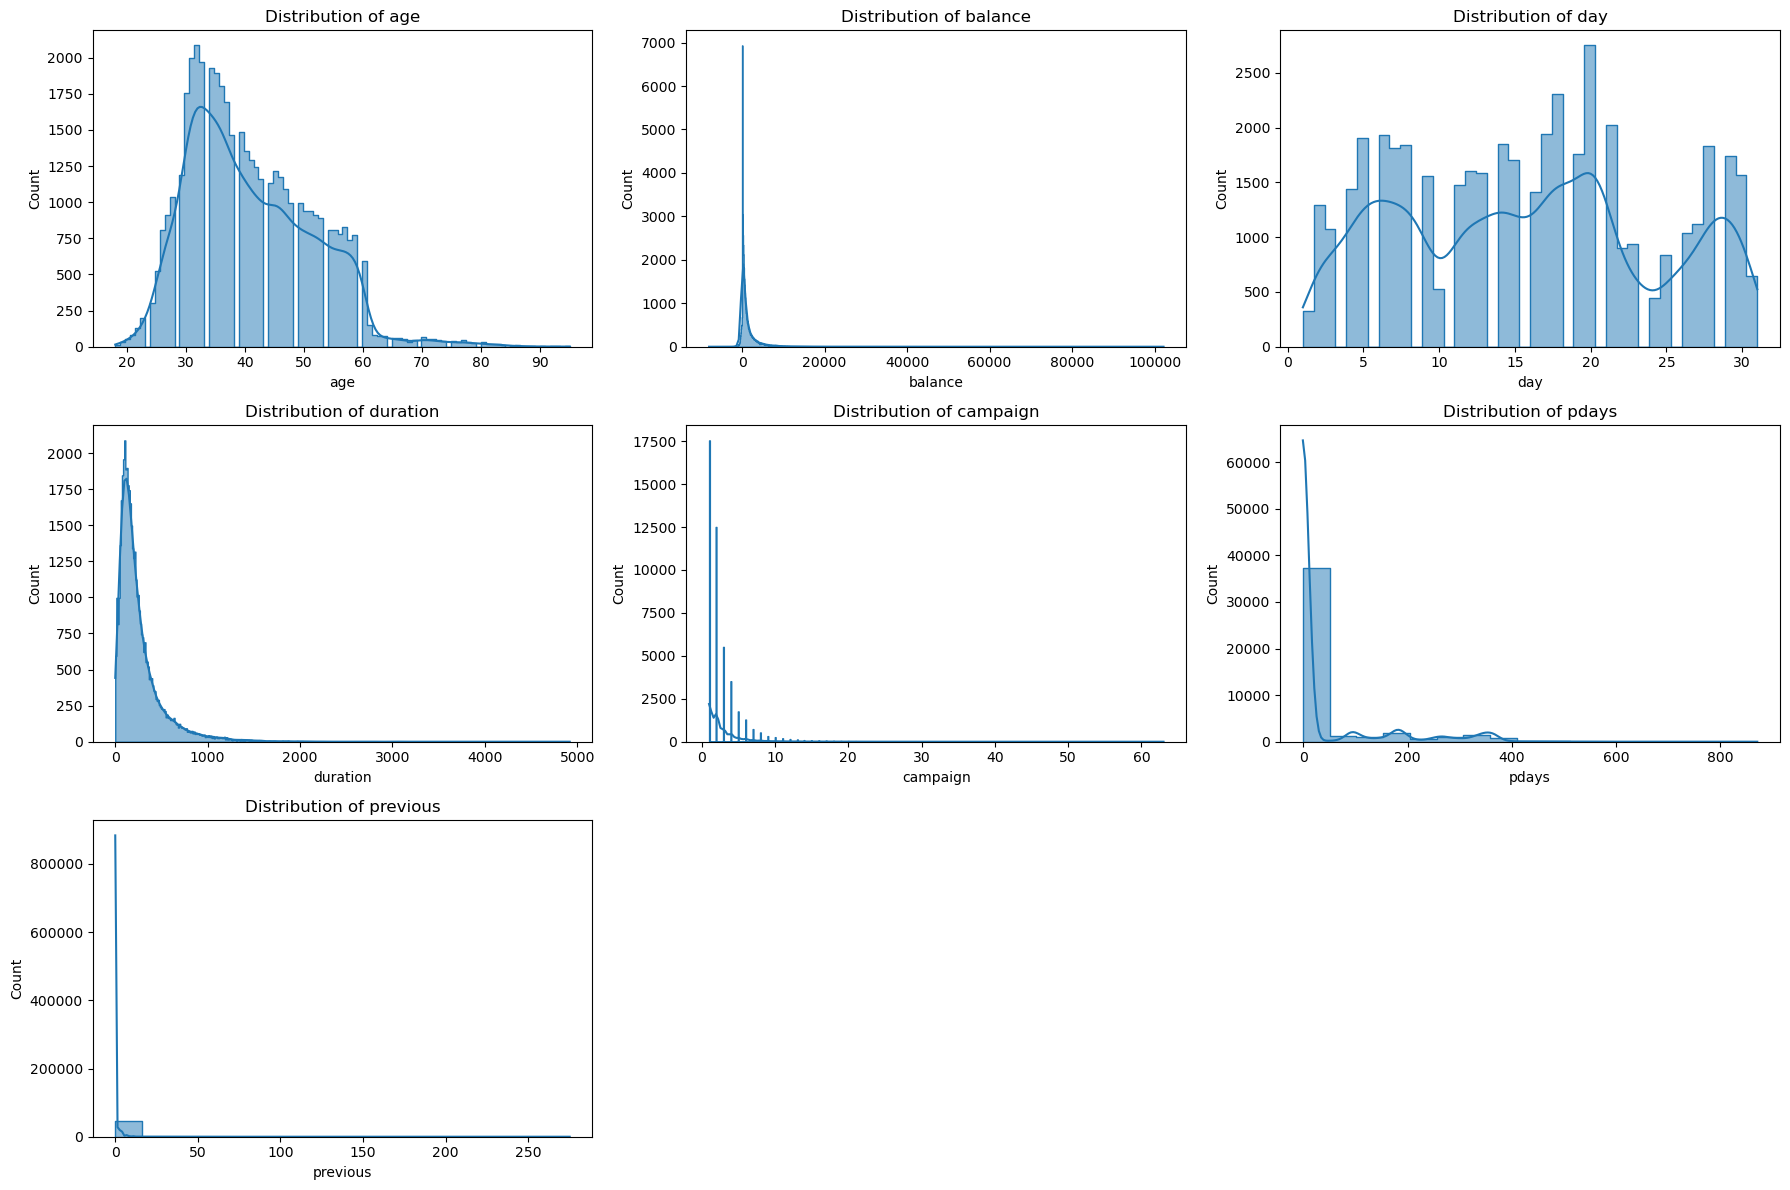

In [9]:
# 1. Identify numerical columns (without target)
numerical_cols = train_bank_file.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'y' in numerical_cols:
    numerical_cols.remove('y')

# 2. Plot distributions using histograms for each numerical feature split by 'y'
n_cols = 3
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(6 * n_cols, 4 * n_rows))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(data=train_bank_file, x=col,  kde=True, element='step', palette='Set2')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


#### Key Numerical Insights

Longer call durations were highly correlated with positive outcomes — indicating that engaged conversations boost conversion.

Clients with higher balances and fewer past failures (lower previous, pdays) were more likely to subscribe.

Older individuals (age group 60+) showed more interest in term deposits than younger groups.



#### Outlier Observation: 
- Significant outliers in `balance` and `duration` need careful consideration.
- Techniques like log transformation, capping, or using tree-based models (e.g., Random Forest) help mitigate outlier influence.


### Categorical Feature Distributions with Target Overlay

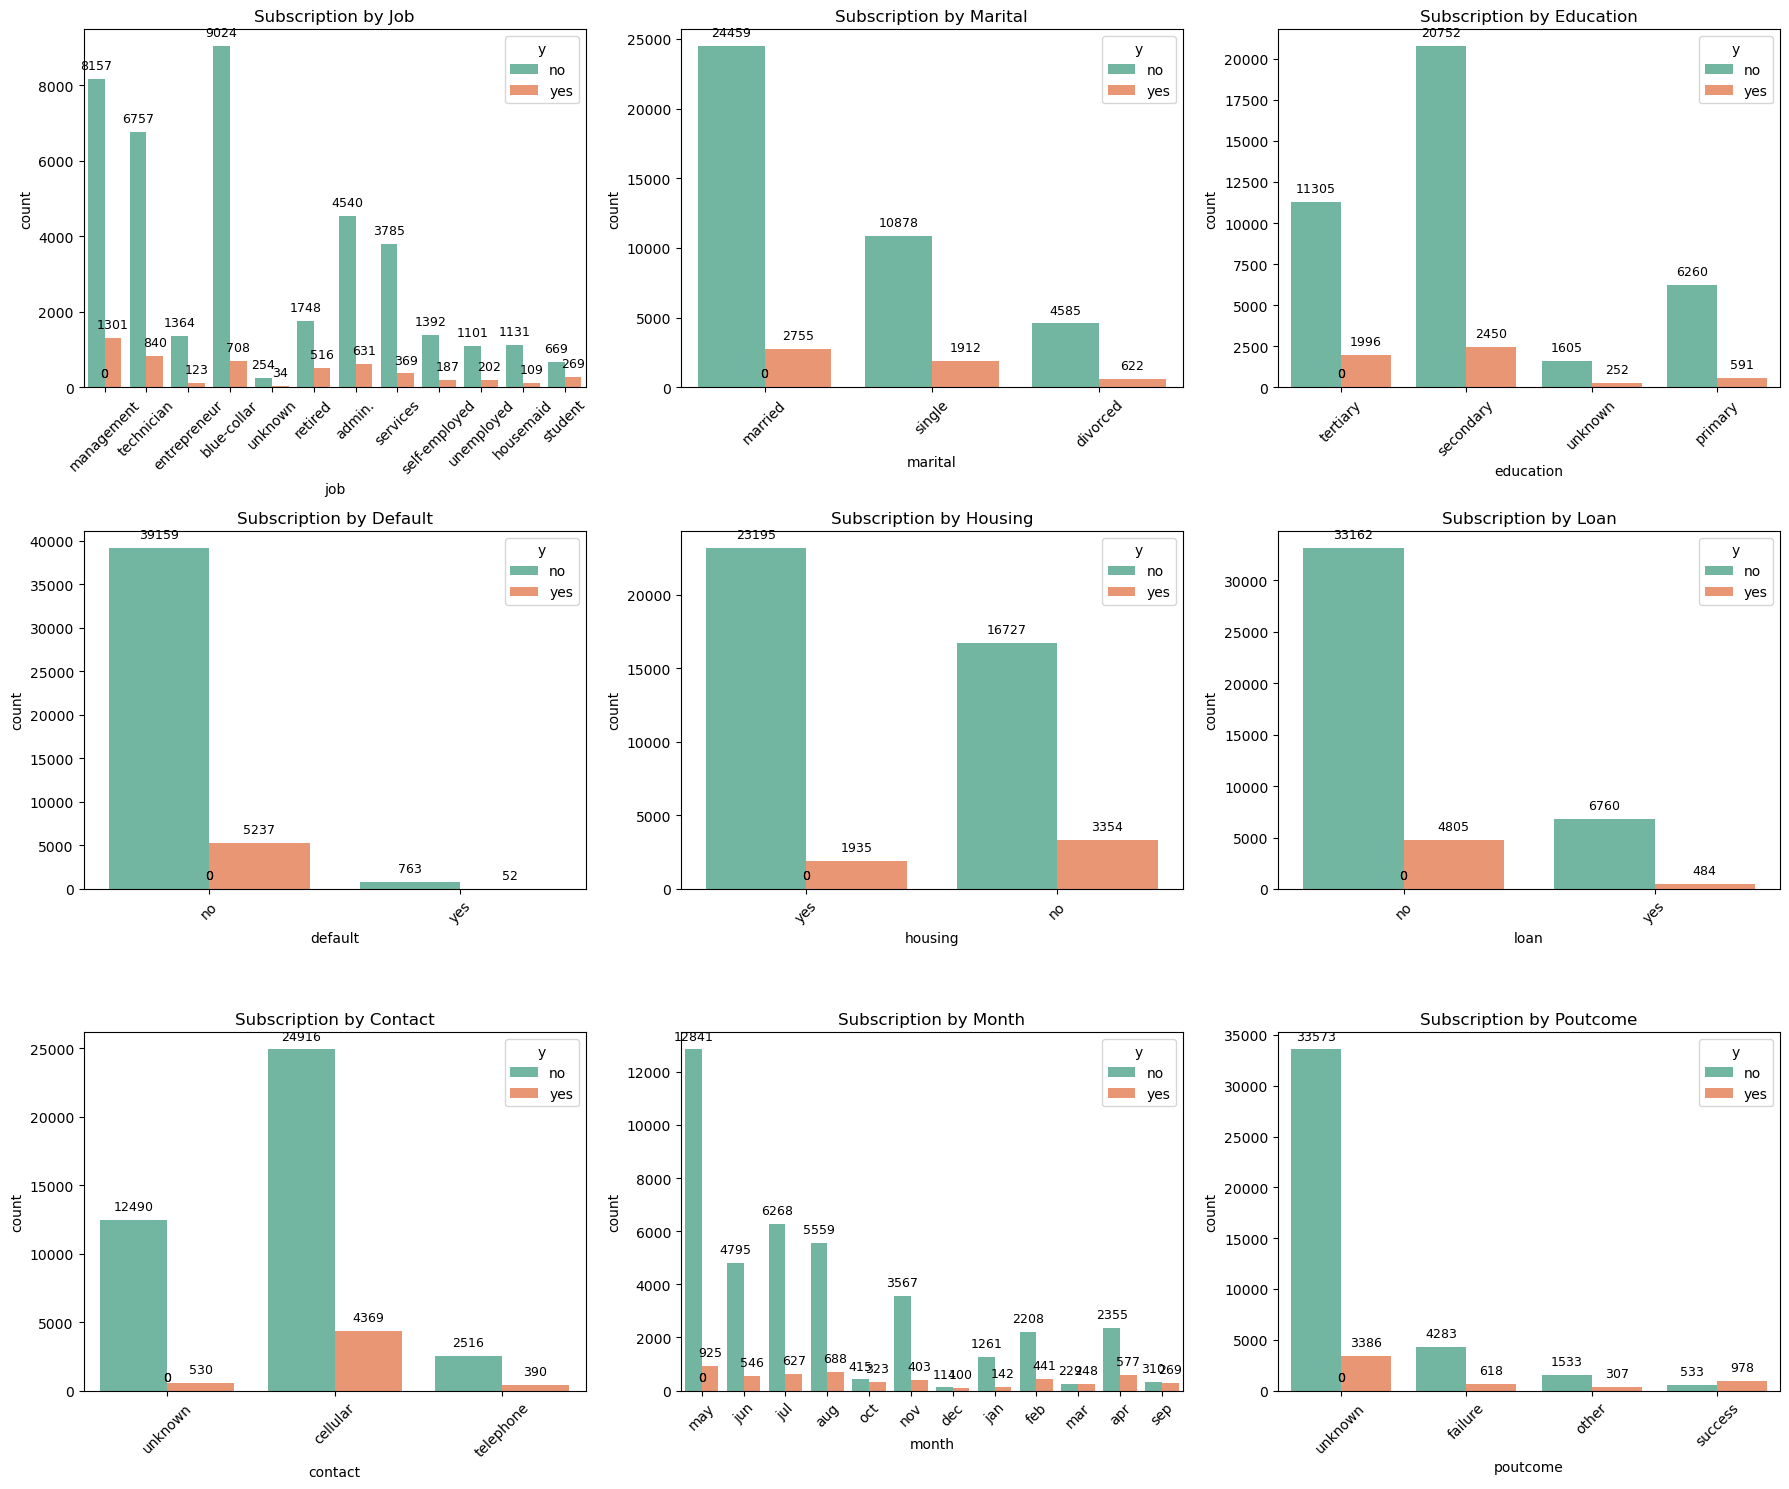

In [10]:
# Identify categorical columns (without target)
categorical_cols = train_bank_file.select_dtypes(include='object').columns.drop('y')

# Subplot grid setup
n_cols = 3
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

# Loop through each categorical column
for i, col in enumerate(categorical_cols):
    ax = axes[i]
    sns.countplot(x=col, hue='y', data=train_bank_file, palette='Set2', ax=ax)
    ax.set_title(f'Subscription by {col.capitalize()}')
    ax.tick_params(axis='x', rotation=45)

    # Adding data labels
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9, color='black', xytext=(0, 5), textcoords='offset points')

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### Top Categorical Influencers

Features like poutcome (previous campaign outcome), contact method, education, and job type showed clear differences in subscription rates.

Clients with a previous successful campaign (poutcome = success) had significantly higher subscription rates.

Cellular contacts were more effective than telephone or unknown types.

Those with tertiary education were more likely to subscribe than those with primary or unknown education.


###  Feature Engineering

In [11]:
# creating new features

# creating new column(was previously contacted)
train_bank_file['was_previously_contacted'] = (train_bank_file['pdays'] != -1).astype(int)

# creating new column(age group)
train_bank_file['age_group'] = pd.cut(train_bank_file['age'], bins=[17, 25, 35, 45, 55, 65, 100], 
                                 labels=['18–25', '26–35', '36–45', '46–55', '56–65', '66+'])

#creating new column(balance group)
train_bank_file['balance_group'] = pd.cut(train_bank_file['balance'], 
                                     bins=[-10000, 0, 1000, 5000, 10000, 100000],
                                     labels=['Debt', 'Low', 'Medium', 'High','Very High'])

# dropping redundant columns 
columns_to_drop = ['day', 'pdays']

train_bank_file = train_bank_file.drop(columns=columns_to_drop)

#### Feature Engineering Summary:

1. **was_previously_contacted**: Created a binary flag to indicate whether a client was contacted in a previous campaign (`pdays` ≠ -1). This simplifies modeling and improves interpretability.

2. **age_group**: Grouped continuous age values into bins (18–25, 26–35, ..., 66+) to help identify patterns across age ranges and reduce model complexity.

3. **balance_group**: Categorized account balances into tiers (Debt, Low, Medium, High, Very High) to make it easier to compare subscription rates across financial statuses and handle outliers in balance.


4. **day**: The day of the month on which contact was made does not have a meaningful impact on the outcome and may introduce noise.
5. **pdays**: This column was used to create the new feature `was_previously_contacted` and is no longer needed in its raw form.

Removing these helps simplify the dataset and reduce potential multicollinearity.



In [12]:
# Define columns with 'yes'/'no' values that can be mapped to 1/0
binary_columns = ['default', 'housing', 'loan', 'y']



# Convert 'yes'/'no' to 1/0
for col in binary_columns:
    train_bank_file[col] = train_bank_file[col].map({'yes': 1, 'no': 0})

# Optional: Convert categorical columns to category codes
categorical_columns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome', 'age_group', 'balance_group']

for col in categorical_columns:
    train_bank_file[col] = train_bank_file[col].astype('category').cat.codes

print(train_bank_file.dtypes)

age                         int64
job                          int8
marital                      int8
education                    int8
default                     int64
balance                     int64
housing                     int64
loan                        int64
contact                      int8
month                        int8
duration                    int64
campaign                    int64
previous                    int64
poutcome                     int8
y                           int64
was_previously_contacted    int32
age_group                    int8
balance_group                int8
dtype: object


#### Encoding Summary

To prepare the data for modeling, binary columns with "yes"/"no" values were converted to 1 and 0. Additionally, categorical columns such as job type, education level, and contact method were transformed into numeric codes. This encoding ensures the dataset is fully numeric, making it suitable for machine learning algorithms that require numerical input.

In [13]:
# creating new features fot test set

# creating new column(was previously contacted)
test_bank_file['was_previously_contacted'] = (test_bank_file['pdays'] != -1).astype(int)

# creating new column(age group)
test_bank_file['age_group'] = pd.cut(test_bank_file['age'], bins=[17, 25, 35, 45, 55, 65, 100], 
                                 labels=['18–25', '26–35', '36–45', '46–55', '56–65', '66+'])

#creating new column(balance group)
test_bank_file['balance_group'] = pd.cut(test_bank_file['balance'], 
                                     bins=[-10000, 0, 1000, 5000, 10000, 100000],
                                     labels=['Debt', 'Low', 'Medium', 'High','Very High'])

# dropping columns 
columns_to_drop = ['day', 'pdays']  # remove columns as needed

test_bank_file = test_bank_file.drop(columns=columns_to_drop)

In [14]:
# encoding categorical columns 

# Define columns with 'yes'/'no' values that can be mapped to 1/0
binary_columns = ['default', 'housing', 'loan', 'y']



# Convert 'yes'/'no' to 1/0
for col in binary_columns:
    test_bank_file[col] = test_bank_file[col].map({'yes': 1, 'no': 0})

# Convert categorical columns to category codes
categorical_columns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome', 'age_group', 'balance_group']

for col in categorical_columns:
    test_bank_file[col] = test_bank_file[col].astype('category').cat.codes

print(test_bank_file.dtypes)

age                         int64
job                          int8
marital                      int8
education                    int8
default                     int64
balance                     int64
housing                     int64
loan                        int64
contact                      int8
month                        int8
duration                    int64
campaign                    int64
previous                    int64
poutcome                     int8
y                           int64
was_previously_contacted    int32
age_group                    int8
balance_group                int8
dtype: object


In [15]:
#feature selection
X_train =train_bank_file.drop(columns=['y'])
y_train =train_bank_file['y']


X_test = test_bank_file.drop('y', axis=1)
y_test = test_bank_file['y']

#### Feature Selection Summary

The dataset was split into features (X) and target (y) variables for both the training and testing sets. The target variable y represents whether a client subscribed to a term deposit, while all other relevant columns are retained in X for modeling. This setup prepares the data for training and evaluating machine learning models.

In [16]:
# Applying SMOTE to training set to limit imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())



Before SMOTE: y
0    39922
1     5289
Name: count, dtype: int64
After SMOTE: y
0    39922
1    39922
Name: count, dtype: int64


#### Handling Imbalanced Data with SMOTE

The original training data exhibited class imbalance, with significantly more clients not subscribing to a term deposit. To address this, SMOTE (Synthetic Minority Oversampling Technique) was applied to generate synthetic samples for the minority class.

**Before SMOTE**: The dataset was skewed toward the 'no' class.

**After SMOTE**: Both classes were balanced, allowing models to learn equally from both subscription outcomes and reducing bias toward the majority class.

This step improves the model's ability to generalize, especially when predicting rare outcomes like term deposit subscriptions.

In [17]:
#  Fitting Models After SMOTE

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(random_state=42)

In [18]:

# Logistic Regression
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_resampled, y_train_resampled)



LogisticRegression(max_iter=1000, random_state=42)

In [19]:
# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)


**All models were trained using the SMOTE-balanced dataset to address class imbalance.**

In [20]:
# making predictions with x_test

models = {
    "Logistic Regression": log_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model
}

for name, model in models.items():
    print(f"\n🔍 {name}")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))



🔍 Logistic Regression
              precision    recall  f1-score   support

           0       0.94      0.85      0.90      4000
           1       0.35      0.60      0.44       521

    accuracy                           0.82      4521
   macro avg       0.65      0.73      0.67      4521
weighted avg       0.87      0.82      0.84      4521


🔍 Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4000
           1       1.00      1.00      1.00       521

    accuracy                           1.00      4521
   macro avg       1.00      1.00      1.00      4521
weighted avg       1.00      1.00      1.00      4521


🔍 XGBoost
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      4000
           1       0.62      0.72      0.67       521

    accuracy                           0.92      4521
   macro avg       0.79      0.83      0.81      4521
weighted avg       0.92

#### Model Summary:
1. **Logistic Regression**: 82% accuracy, good baseline but low precision on subscribers.
2. **Random Forest**: 100% accuracy, likely overfitting.
3. **XGBoost**: 92% accuracy, best balance with strong recall (72%) on subscribers.

#### Recommendation:
Use XGBoost for deployment due to its balanced performance, with the potential for improved results through hyperparameter tuning and cross-validation to mitigate overfitting.


In [21]:
# Generate predictions on the test set
rf_preds = rf_model.predict(X_test)
log_preds = log_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)


In [22]:
# **Comparing the models**

# Store metrics for each model
results = {}

models = {
    "Logistic Regression": log_preds,
    "Random Forest": rf_preds,
    "XGBoost": xgb_preds
}

for model_name, preds in models.items():
    results[model_name] = {
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds),
        "Recall": recall_score(y_test, preds),
        "F1 Score": f1_score(y_test, preds)
    }

# Create DataFrame for easy comparison
results_df = pd.DataFrame(results).T
results_df = results_df.round(3)

print("\n Model Performance Comparison:")
print(results_df)



 Model Performance Comparison:
                     Accuracy  Precision  Recall  F1 Score
Logistic Regression     0.825      0.349   0.603     0.442
Random Forest           1.000      1.000   1.000     1.000
XGBoost                 0.918      0.625   0.720     0.669


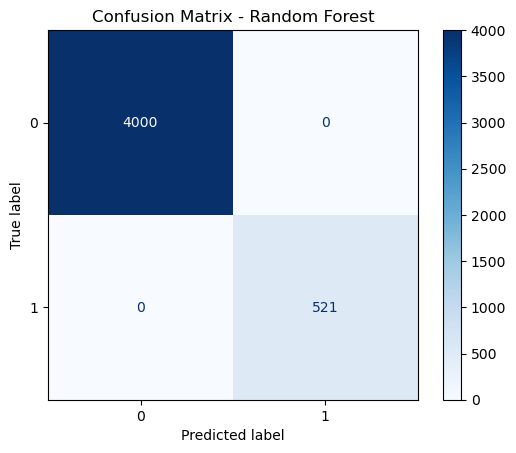

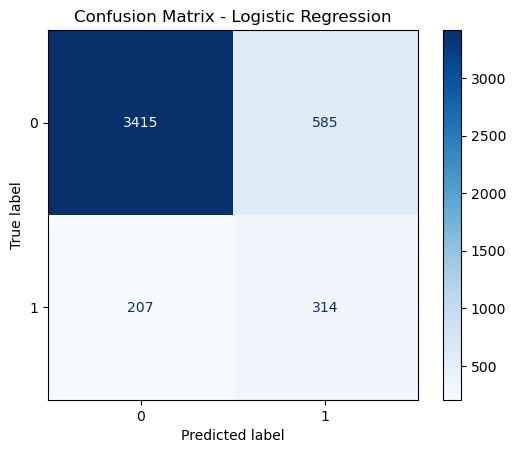

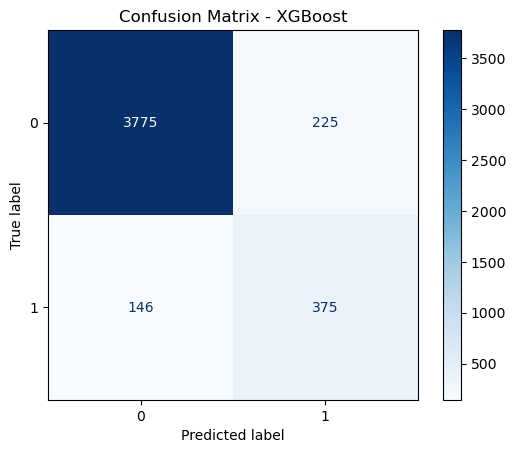

In [23]:
# using confusion metrix to visualize the prediction outcome
models = {
    "Random Forest": rf_preds,
    "Logistic Regression": log_preds,
    "XGBoost": xgb_preds
}

for model_name, preds in models.items():
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


The evaluated model predictions using confusion matrices, compares predicted and actual class labels.

**Random Forest model** achieved perfect accuracy but showed signs of overfitting, making it unreliable for generalization. 

**Logistic Regression** struggled with predicting the minority class (1), producing high false positives and false negatives.

**XGBoost** demonstrated the best balance between sensitivity (recall) and specificity, making it a robust choice for deployment.

The confusion matrix charts clearly illustrate each model’s strengths and limitations in classification performance.

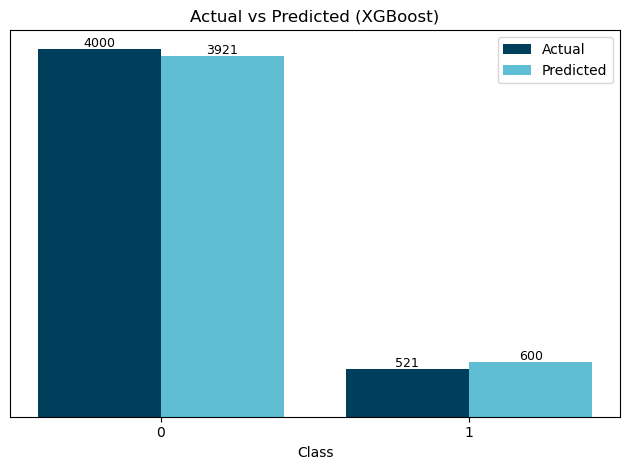

In [24]:
# Count of actual and predicted values
actual_counts = y_test.value_counts().sort_index()
predicted_counts = pd.Series(xgb_preds).value_counts().sort_index()

# Define class labels and x-axis positions
labels = [0, 1]
x = range(len(labels))

# Custom colors
actual_color = '#003f5c'     # Deep Blue
predicted_color =  '#5FBED3'  # coral Blue

# Create bar plot
plt.bar(x, actual_counts, width=0.4, label='Actual', align='center', color=actual_color)
plt.bar([i + 0.4 for i in x], predicted_counts, width=0.4, label='Predicted', align='center', color=predicted_color)

# Add data labels on top of bars
for i in x:
    plt.text(i, actual_counts[i] + 20, str(actual_counts[i]), ha='center', fontsize=9)
    plt.text(i + 0.4, predicted_counts[i] + 20, str(predicted_counts[i]), ha='center', fontsize=9)

# Final plot adjustments
plt.xticks([i + 0.2 for i in x], labels)
plt.xlabel("Class")
plt.title("Actual vs Predicted (XGBoost)")
plt.legend()
plt.yticks([])  # Remove y-axis ticks
plt.tight_layout()
plt.show()



The bar chart compares actual vs. predicted class counts using the XGBoost model.

**Class 0 (Not Subscribed)**: Predicted 3921 vs. Actual 4000

**Class 1 (Subscribed)**: Predicted 600 vs. Actual 521

XGBoost slightly over-predicts subscriptions but overall captures both classes well, showing balanced performance after SMOTE

## Common Characteristics of Subscribers to consider
1. #### Higher balance

2. #### Previously successful marketing interactions

3. #### Contacted via cellular phone

4. #### Engaged in longer conversations

4. #### Often retired or in management

5. #### Typically contacted in May, August, or October

## Actionable Recommendations for the Marketing Team
1. **Target Based on Engagement History**

Prioritize clients with successful previous campaign outcomes.

2. **Channel Optimization**

Use cellular calls over telephone or other unknown contact methods for better engagement.

3. **Timing Matters**

Focus call campaigns during May, August, and October, when response rates peak.

4. **Tailored Messaging for High-Value Clients**

Target retired, self-employed, and management-level clients who historically show higher interest.

5. **Avoid Overcontacting**

Limit the number of calls per client (campaign) to avoid fatigue and reduce negative responses.

6. **Real-Time Call Monitoring**

Use call duration as a live KPI — the longer the call, the higher the conversion likelihood.



In [26]:
## Deploying the model

In [27]:
from sklearn.model_selection import GridSearchCV

# Define model and parameters
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

# Grid Search with cross-validation
xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, scoring='f1', n_jobs=-1)
xgb_grid.fit(X_train, y_train)

# Best model
best_xgb_model = xgb_grid.best_estimator_

In [30]:
# Saving the trained model

In [31]:
# Save model to file
joblib.dump(xgb_model, 'xgb_subscription_model.pkl')


['xgb_subscription_model.pkl']